In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time

## Loading CIFAR-10 Dataset + Preprocess


In [22]:
class OneHotEncode:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, label):
        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [23]:
train_size = 50000

val_size = 10000

test_size = 10000

torch.manual_seed(13)
np.random.seed(13)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


label_transform = OneHotEncode(num_classes=10)


train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    target_transform=label_transform,
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
    target_transform=label_transform,
)


train_subset, val_subset = random_split(
    train_dataset, [train_size - val_size, val_size]
)

test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

Files already downloaded and verified
Files already downloaded and verified


In [24]:
classes = train_dataset.classes


print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Dataset Preview


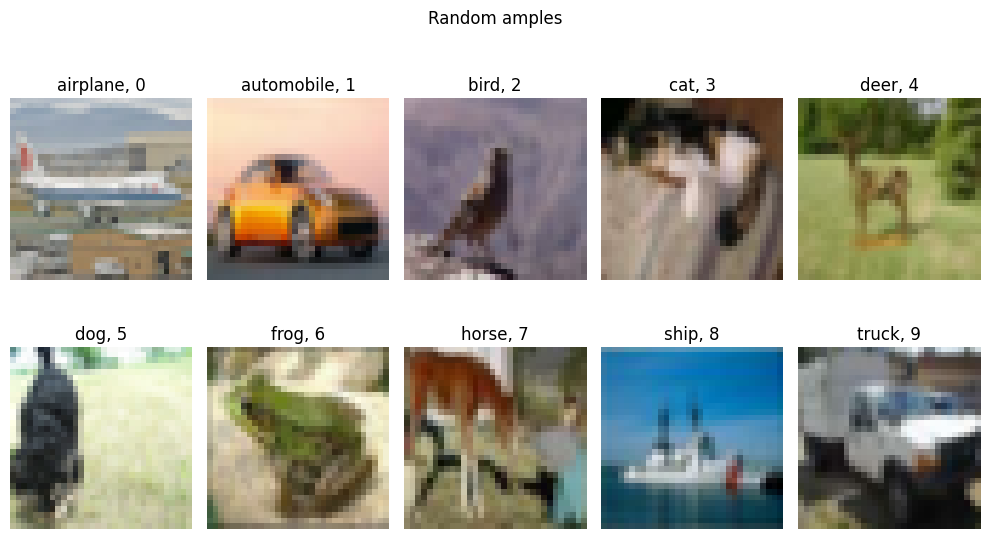

In [25]:
samples = {}


for image, label in train_subset:
    label = torch.argmax(label).item()

    if label not in samples:
        samples[label] = image

    if len(samples) == len(classes):
        break


max_row = 5


fig, axes = plt.subplots(int(len(samples) / max_row), max_row, figsize=[10, 6])


keys = np.sort(list(samples.keys()))


for i, label in enumerate(keys):
    class_name = classes[i]

    sample = samples[i] * 0.5 + 0.5

    sample = sample.numpy().transpose(1, 2, 0)

    ax = axes[int(i / max_row), i % max_row]

    ax.imshow(sample)

    ax.set_title(f"{class_name}, {label}")

    ax.axis("off")


fig.suptitle("Random amples")


plt.tight_layout()


plt.show()

# Converting to Batchs


In [26]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=True)

# Training Model


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device.type}')

device: cuda


In [28]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.relu(x)

        x = self.maxpool(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x


baseline_model = BaselineModel().to(device)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(params=baseline_model.parameters())

In [29]:
def accuracy(y, output):
    y_index = torch.argmax(y, dim=1)

    output_index = torch.argmax(output, dim=1)

    return (y_index == output_index).float().mean().item()

In [30]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=30, log=True):
    train_losses = []

    train_accuracies = []

    validation_losses = []

    validation_accuracies = []

    for epoch in range(epochs):
        batch_loss = 0

        train_acc = 0

        val_acc = 0

        model.train()

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            y_pred = model(X_train)

            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_loss += loss.item() * y_train.shape[0]

            train_acc += accuracy(y_train, y_pred)

        train_losses.append(batch_loss / len(train_loader))

        train_accuracies.append(train_acc / len(train_loader))

        model.eval()

        with torch.no_grad():
            batch_loss = 0

            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val)

                loss = criterion(y_pred, y_val)

                batch_loss += loss.item() * y_val.shape[0]

                val_acc += accuracy(y_val, y_pred)

        validation_losses.append(batch_loss / len(val_loader))

        validation_accuracies.append(val_acc / len(val_loader))

        if log and (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs}, Train loss: {np.round(train_losses[-1], 3)}, Train acc: {np.round(train_accuracies[-1], 3)}, Val loss: {np.round(validation_losses[-1], 3)}, Val acc: {np.round(validation_accuracies[-1], 3)}"
            )

    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [31]:
def plot_acc(train_accuracies, validation_accuracies, epochs):
    plt.figure(figsize=[8, 4])

    plt.plot(
        range(1, epochs + 1),
        train_accuracies,
        c="blue",
        linestyle="--",
        marker="o",
        label="train accuracies",
    )

    plt.plot(
        range(1, epochs + 1),
        validation_accuracies,
        c="red",
        linestyle="--",
        marker="o",
        label="val accuracies",
    )

    plt.ylabel("accuracy")

    plt.xlabel("epoch")

    plt.tight_layout()

    plt.legend()

    plt.show()


def plot_loss(train_losses, validation_losses, epochs):
    plt.figure(figsize=[8, 4])

    plt.plot(
        range(1, epochs + 1),
        train_losses,
        c="blue",
        linestyle="--",
        marker="o",
        label="train loss",
    )

    plt.plot(
        range(1, epochs + 1),
        validation_losses,
        c="red",
        linestyle="--",
        marker="o",
        label="val loss",
    )

    plt.ylabel("loss")

    plt.xlabel("epoch")

    plt.tight_layout()

    plt.legend()

    plt.show()


def save_model(model, path):
    torch.save(model, f=path)

    print(f"model saved to {path} successfully!")

In [32]:
start_time = time.time()


epochs = 30


train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    log=True,
)


end_time = time.time()


print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 100.362, Train acc: 0.461, Val loss: 99.56, Val acc: 0.46
Epoch 20/30, Train loss: 88.025, Train acc: 0.525, Val loss: 88.758, Val acc: 0.517
Epoch 30/30, Train loss: 81.348, Train acc: 0.562, Val loss: 83.407, Val acc: 0.543
time: 676.69 seconds


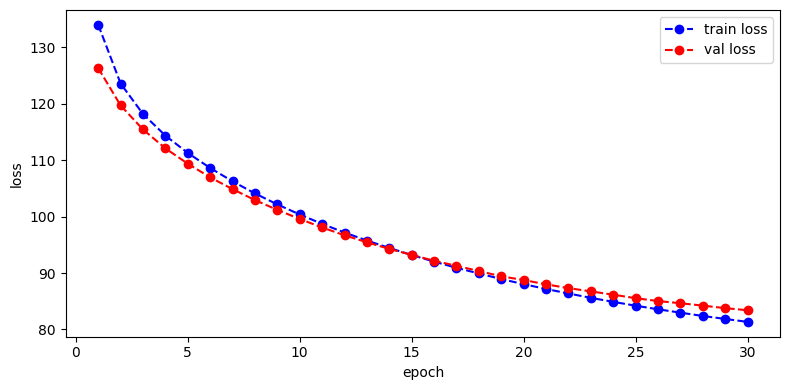

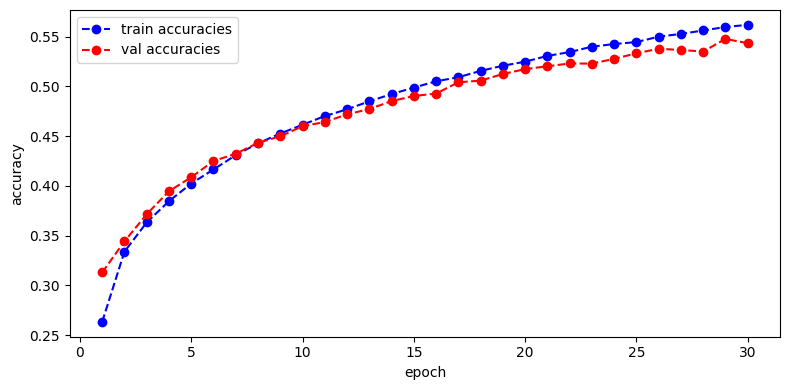

In [33]:
plot_loss(train_losses, validation_losses, epochs=epochs)


plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [34]:
save_model(baseline_model, './baseline')

model saved to ./baseline successfully!


# Model Imporvement


In [35]:
class ImprovedModel(nn.Module):

    def __init__(self):

        super(ImprovedModel, self).__init__()

        self.relu = nn.ReLU()

        # 3 * 32 * 32 -> 64 * 28 * 28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

        # 64 * 14 * 14 -> 64 * 12 * 12
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        # 64 * 6 * 6 -> 63 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.averagepool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc2 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc3 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):

        x = self.conv1(x)

        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.averagepool(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.fc2(x)

        x = self.fc3(x)

        return x


improved_model = ImprovedModel().to(device)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(params=improved_model.parameters())

In [36]:
start_time = time.time()


epochs = 30


train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=improved_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    log=True
)


end_time = time.time()


print(f'time: {np.round(end_time - start_time, 2)} seconds')

Epoch 10/30, Train loss: 143.647, Train acc: 0.223, Val loss: 141.509, Val acc: 0.235
Epoch 20/30, Train loss: 118.042, Train acc: 0.335, Val loss: 116.882, Val acc: 0.336
Epoch 30/30, Train loss: 105.405, Train acc: 0.398, Val loss: 104.822, Val acc: 0.392
time: 657.0 seconds


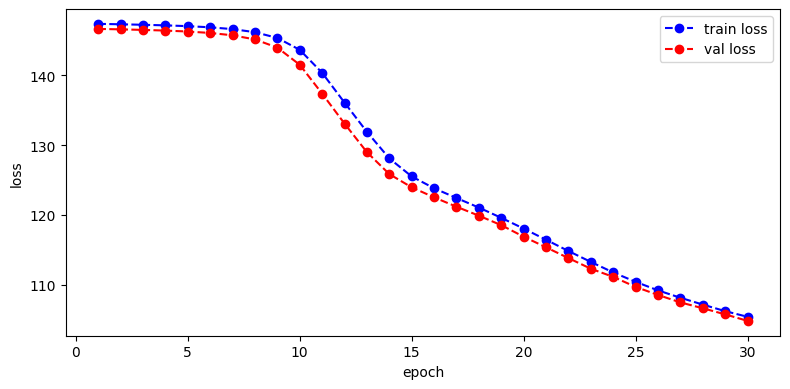

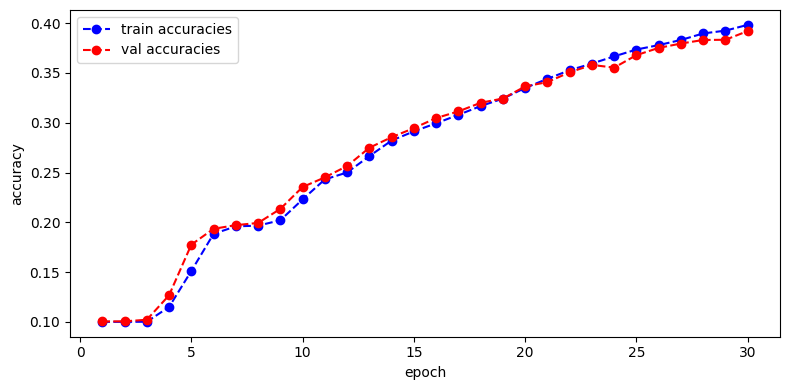

In [37]:
plot_loss(train_losses, validation_losses, epochs=epochs)


plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [38]:
save_model(improved_model, './improvedmodel')

model saved to ./improvedmodel successfully!


# Adding Batch Normalization


In [39]:
class BnModel(nn.Module):
    def __init__(self):
        super(BnModel, self).__init__()

        self.relu = nn.ReLU()

        # 3 * 32 * 32 -> 64 * 28 * 28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

        self.bn1 = nn.BatchNorm2d(64)

        # 64 * 14 * 14 -> 64 * 12 * 12
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.bn2 = nn.BatchNorm2d(64)

        # 64 * 6 * 6 -> 63 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.bn3 = nn.BatchNorm2d(64)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.averagepool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc2 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc3 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.bn1(x)

        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)

        x = self.bn2(x)

        x = self.relu(x)

        x = self.averagepool(x)

        x = self.conv3(x)

        x = self.bn3(x)

        x = self.relu(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.fc2(x)

        x = self.fc3(x)

        return x


bn_model = BnModel().to(device)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(params=bn_model.parameters())

In [40]:
start_time = time.time()


epochs = 30


train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=bn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    log=True,
)


end_time = time.time()


print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 74.219, Train acc: 0.592, Val loss: 73.126, Val acc: 0.597
Epoch 20/30, Train loss: 56.99, Train acc: 0.687, Val loss: 59.863, Val acc: 0.672
Epoch 30/30, Train loss: 47.493, Train acc: 0.741, Val loss: 53.404, Val acc: 0.702
time: 717.4 seconds


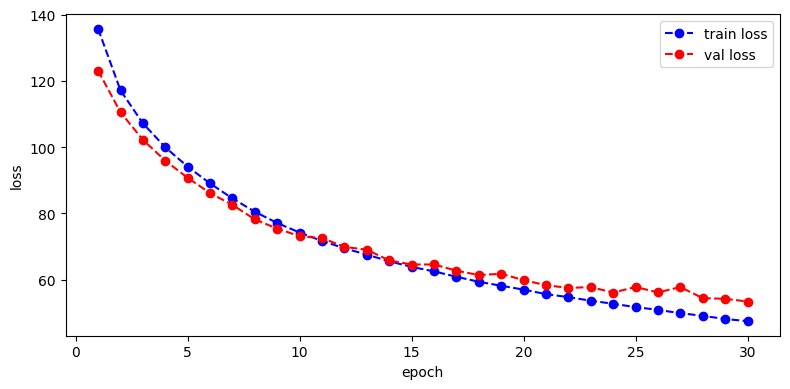

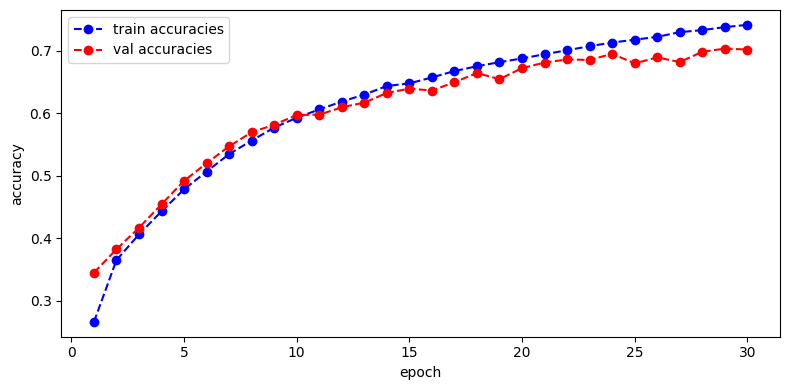

In [41]:
plot_loss(train_losses, validation_losses, epochs=epochs)


plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [42]:
save_model(bn_model, './bnmodel')

model saved to ./bnmodel successfully!


# Adding Dropout


In [43]:
class DoModel(nn.Module):
    def __init__(self):
        super(DoModel, self).__init__()

        self.relu = nn.ReLU()

        # 3 * 32 * 32 -> 64 * 28 * 28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

        self.bn1 = nn.BatchNorm2d(64)

        # 64 * 14 * 14 -> 64 * 14 * 14
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.bn2 = nn.BatchNorm2d(64)

        # 64 * 6 * 6 -> 63 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.bn3 = nn.BatchNorm2d(64)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.averagepool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc2 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)

        self.fc3 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.bn1(x)

        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)

        x = self.bn2(x)

        x = self.relu(x)

        x = self.averagepool(x)

        x = self.conv3(x)

        x = self.bn3(x)

        x = self.relu(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.fc2(x)

        x = self.fc3(x)

        return x


do_model = DoModel().to(device)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(params=do_model.parameters())

In [44]:
start_time = time.time()


epochs = 30


train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=do_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    log=True,
)


end_time = time.time()


print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 74.696, Train acc: 0.585, Val loss: 73.628, Val acc: 0.594
Epoch 20/30, Train loss: 57.894, Train acc: 0.681, Val loss: 60.999, Val acc: 0.662
Epoch 30/30, Train loss: 47.856, Train acc: 0.739, Val loss: 56.211, Val acc: 0.693
time: 722.91 seconds


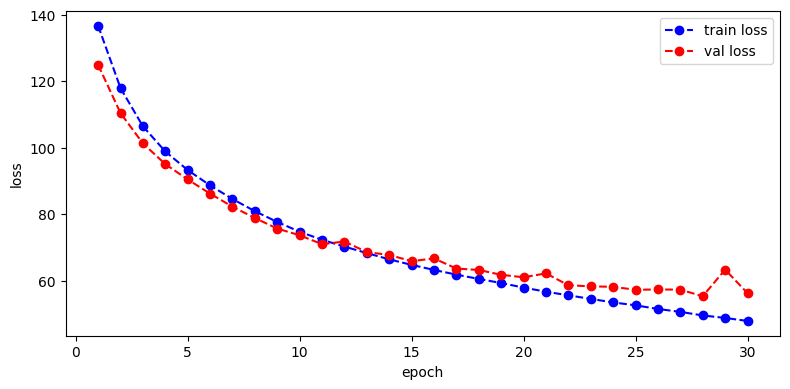

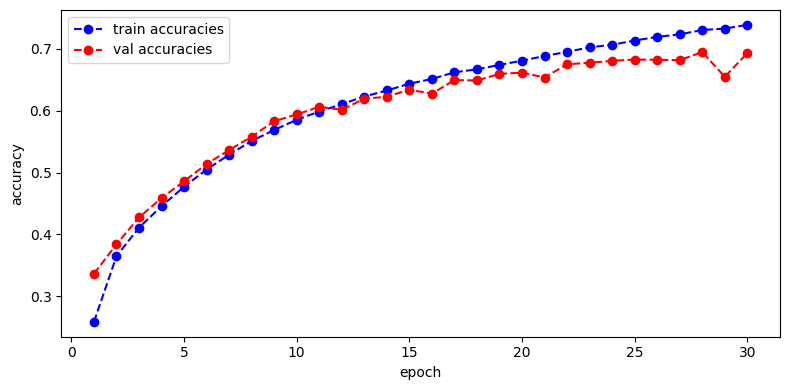

In [45]:
plot_loss(train_losses, validation_losses, epochs=epochs)


plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [46]:
save_model(bn_model, './domodel')

model saved to ./domodel successfully!


# Test and Confusion Matrix


In [47]:
def test(model, test_loader, criterion):

    test_loss = 0

    test_accuracy = 0

    all_preds = []

    all_labels = []

    baseline_model.eval()

    with torch.no_grad():

        for X_test, y_test in test_loader:

            X_test, y_test = X_test.to(device), y_test.to(device)

            y_pred = model(X_test)

            loss = criterion(y_pred, y_test)

            test_loss += loss.item() * y_test.shape[0]

            test_accuracy += accuracy(y_test, y_pred)

            all_labels.extend(torch.argmax(y_test, dim=1).cpu().numpy())

            all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())

        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)

    return test_loss, test_accuracy, all_preds, all_labels

In [48]:
def plot_confusion_matrix(all_labels, all_preds, class_names, title):

    cm = confusion_matrix(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues)

    plt.title(title)

    plt.show()

baseline model:
loss= 83.361, accuracy= 0.542


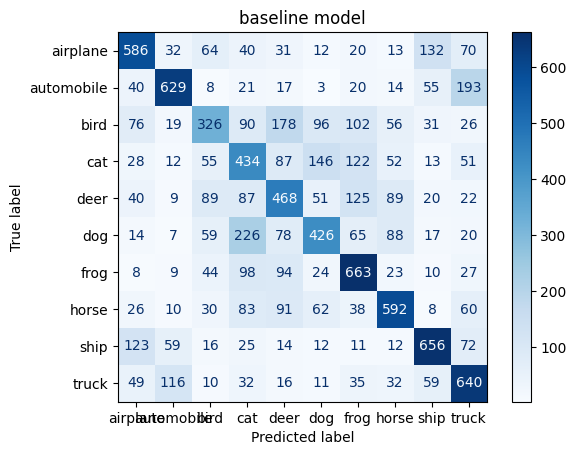

improved model:
loss= 103.888, accuracy= 0.403


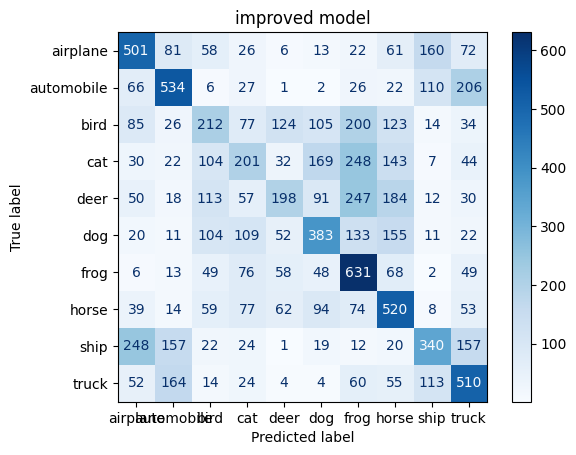

batch normalization model
loss= 52.81, accuracy= 0.707


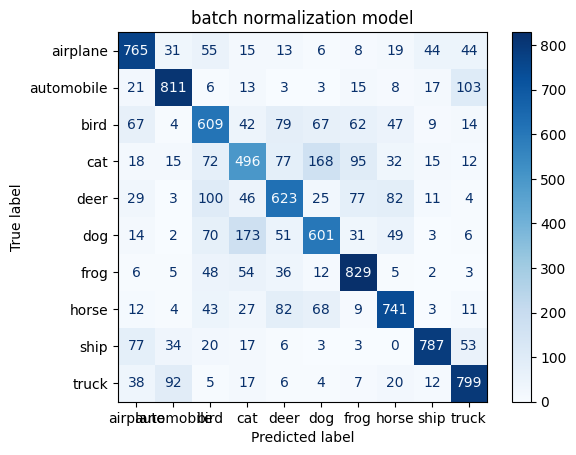

dropout model
loss= 55.302, accuracy= 0.694


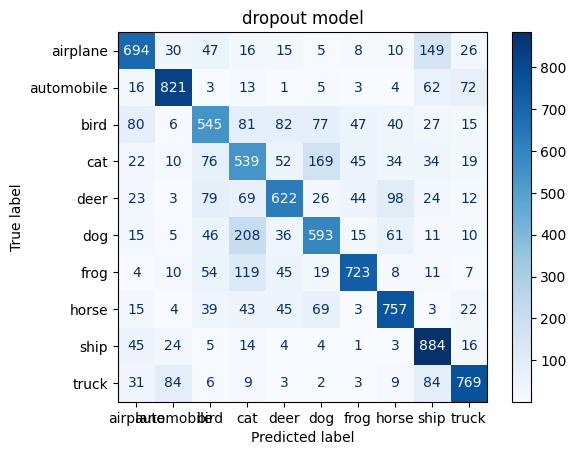

In [49]:
base_loss, base_accuracy, base_preds, base_labels = test(
    model=baseline_model, test_loader=test_loader, criterion=criterion)


print('baseline model:')


print(f'loss= {np.round(base_loss, 3)}, accuracy= {np.round(base_accuracy, 3)}')


plot_confusion_matrix(base_labels, base_preds,
                      class_names=classes, title='baseline model')


improved_loss, improved_accuracy, improved_preds, improved_labels = test(
    model=improved_model, test_loader=test_loader, criterion=criterion)


print('improved model:')


print(
    f'loss= {np.round(improved_loss, 3)}, accuracy= {np.round(improved_accuracy, 3)}')


plot_confusion_matrix(improved_labels, improved_preds,
                      class_names=classes, title='improved model')


bn_loss, bn_accuracy, bn_preds, bn_labels = test(
    model=bn_model, test_loader=test_loader, criterion=criterion)


print('batch normalization model')


print(f'loss= {np.round(bn_loss, 3)}, accuracy= {np.round(bn_accuracy, 3)}')


plot_confusion_matrix(bn_labels, bn_preds, class_names=classes,
                      title='batch normalization model')


do_loss, do_accuracy, do_preds, do_labels = test(
    model=do_model, test_loader=test_loader, criterion=criterion)


print('dropout model')


print(f'loss= {np.round(do_loss, 3)}, accuracy= {np.round(do_accuracy, 3)}')


plot_confusion_matrix(do_labels, do_preds,
                      class_names=classes, title='dropout model')